In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

import cmap

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
sns.set_style("white")


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


## Analysis of single-cell transcriptomics data from mouse oocytes.


We process a gene-expression matrix and construct a k-nearest neighbourhood graph. Then we embed this graph in a low-dimensional space by using truncated contagion maps.

For the pre-processing of the expression data we follow current best practices as outlined in the tutorial
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

/Users/fklimm/mambaforge/envs/TDA/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.0.dev9+g9018e16c anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [4]:
# load the data
# The data can be downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE114822
adata = sc.read_text('./../data/GSE114822_mOocy_rna_rawCounts.txt')

### Preprocessing

In [5]:
adata=adata.transpose() # flip observations and gene counts

In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


### Preprocessing

normalizing counts per cell
    finished (0:00:00)


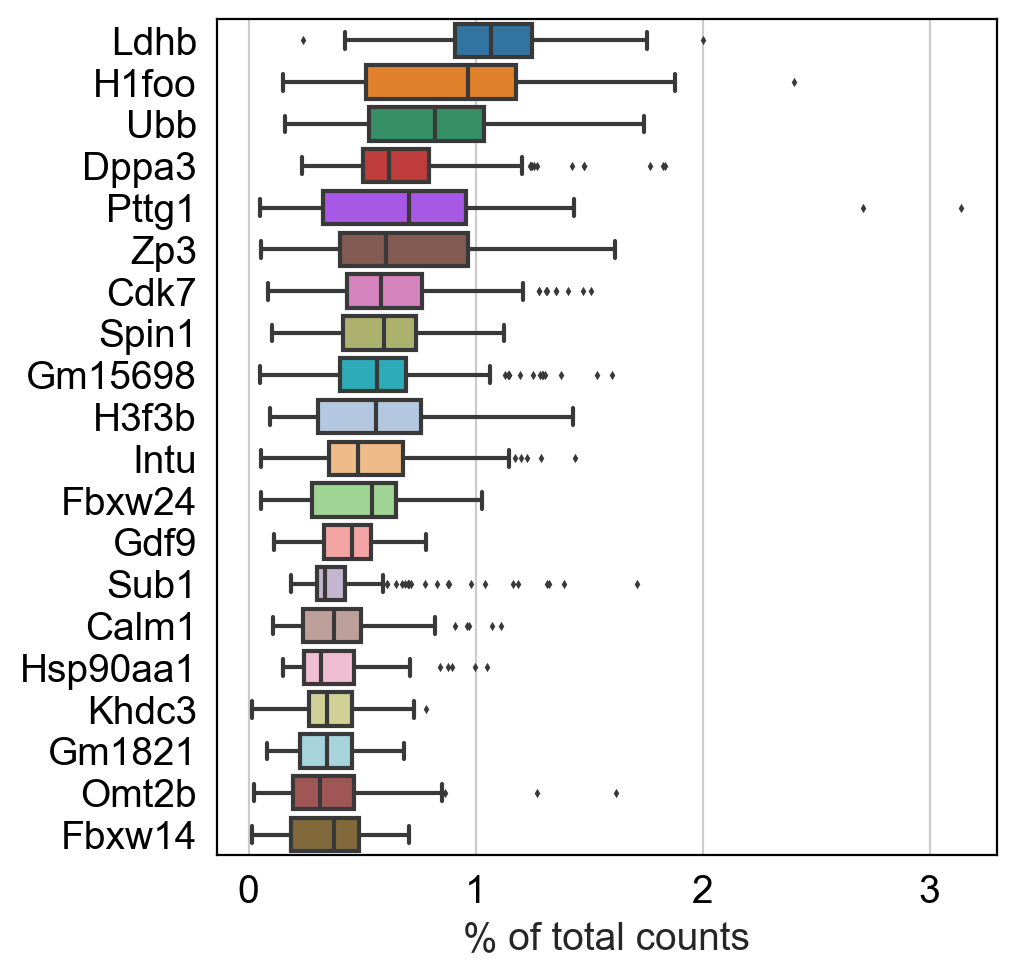

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 5937 genes that are detected in less than 3 cells


In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


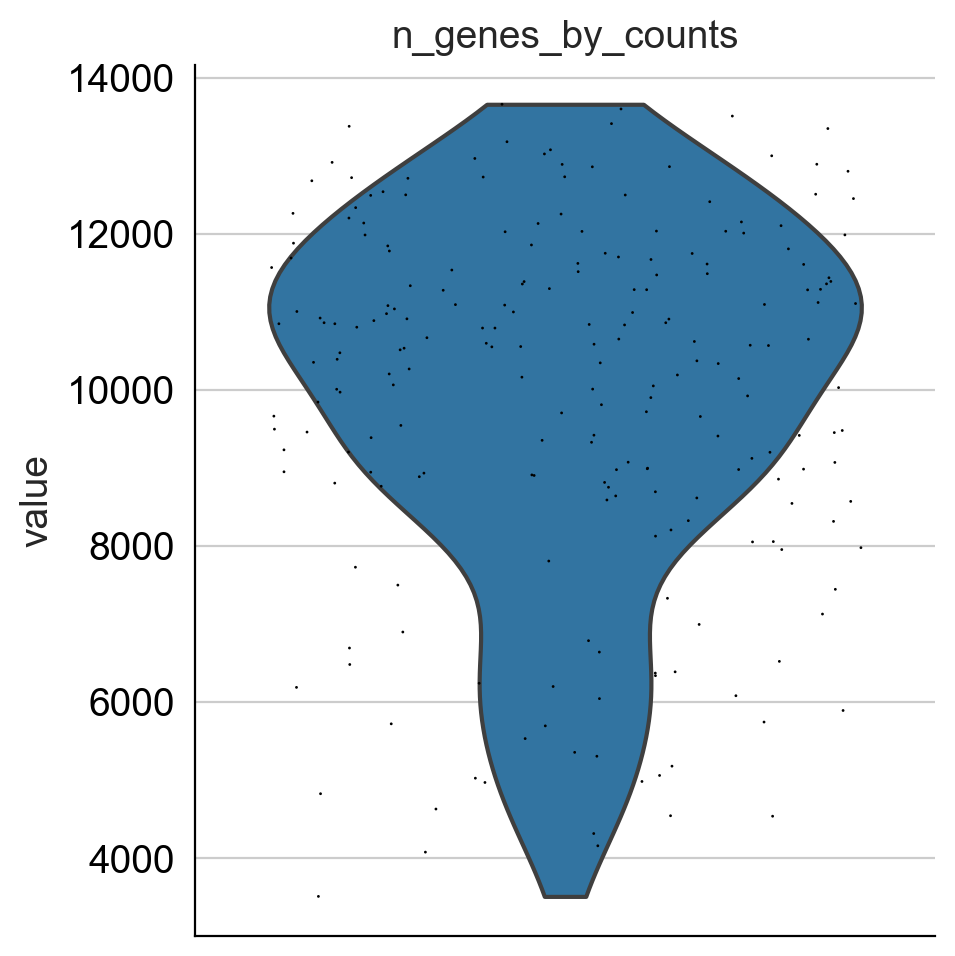

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts'],
             jitter=0.4, multi_panel=True)


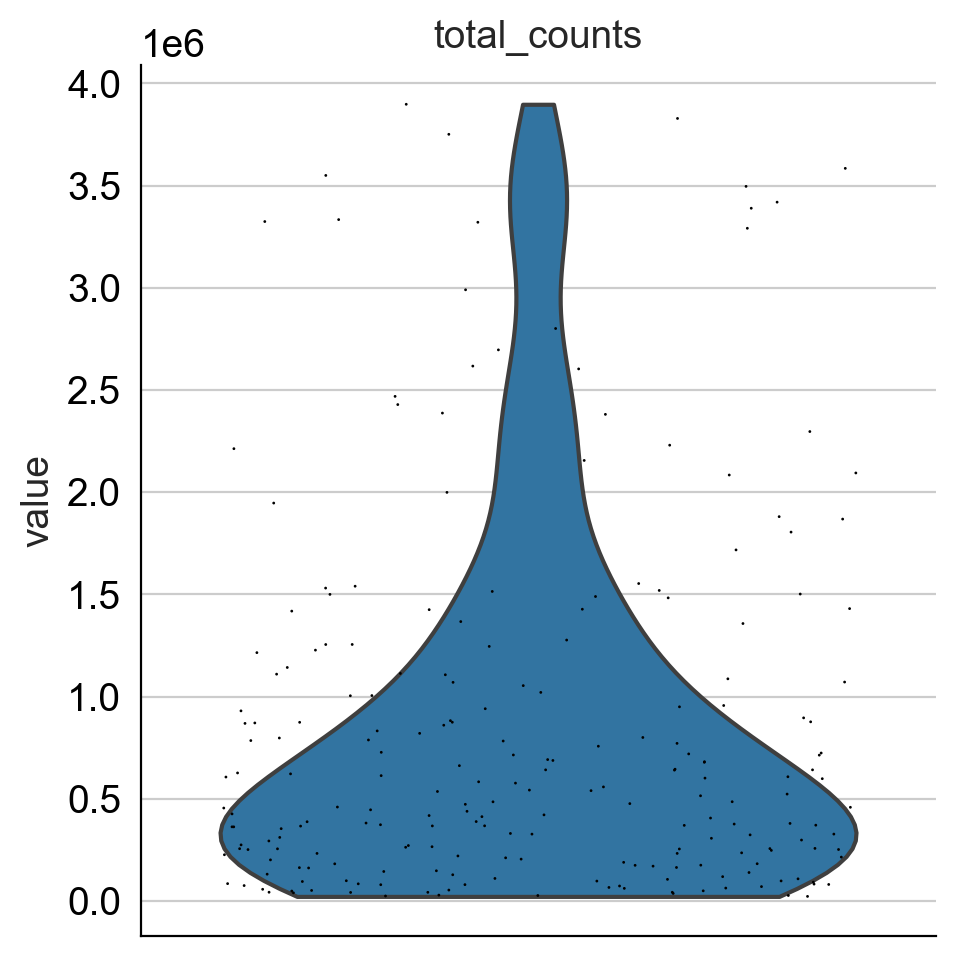

In [11]:
sc.pl.violin(adata, [ 'total_counts'],
             jitter=0.4, multi_panel=True)


In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


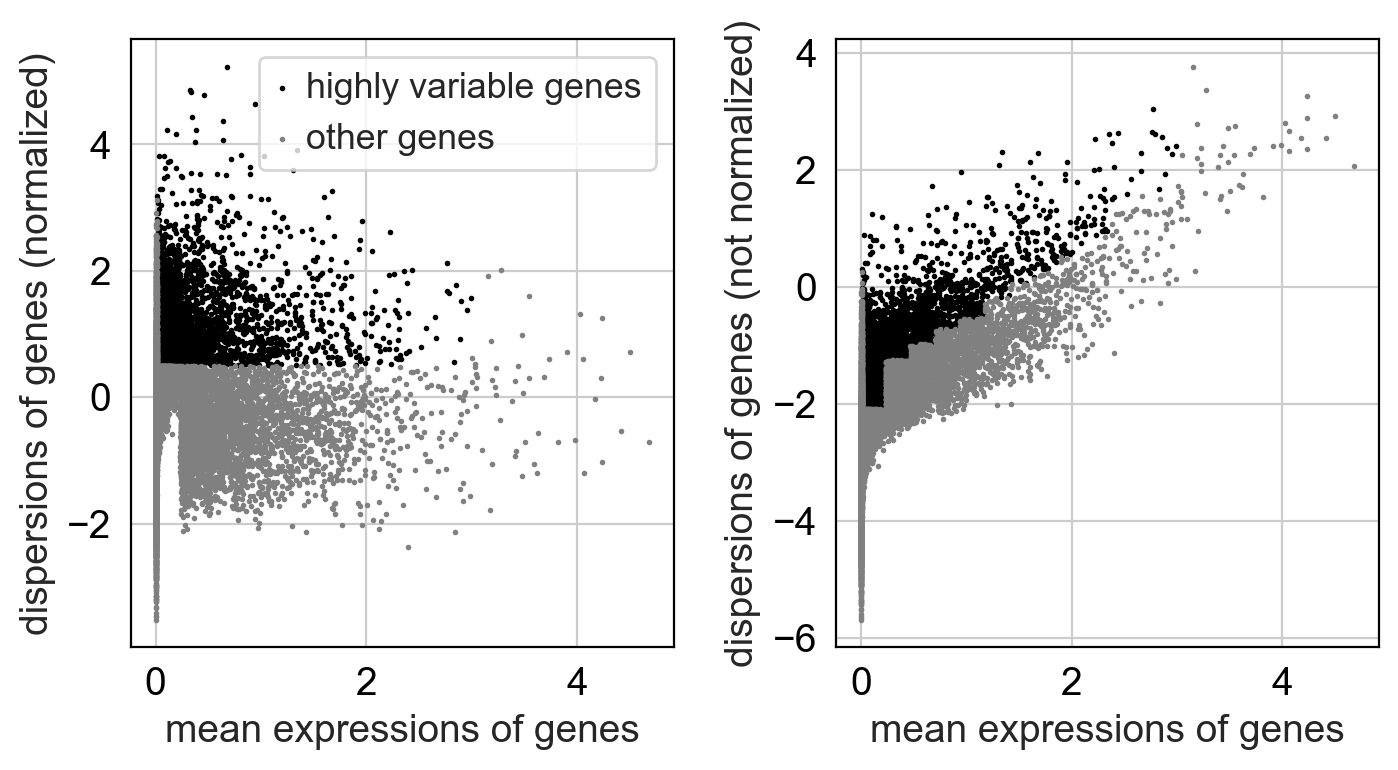

In [13]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)


In [14]:
### add metadata
oocytePhase = [item[0:3] for item in adata.obs_names]

# rename the stages
dic = {'NGO':'primordial', 'GO1':'primary', 'GO2':'secondary', 'GO3':'tertiary','FGO':'antral'}
oocytePhaseRenamed=[dic.get(n, n) for n in oocytePhase]


# 
adata.obs['stage'] = oocytePhaseRenamed

## Actual analysis

#### PCA

In [15]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


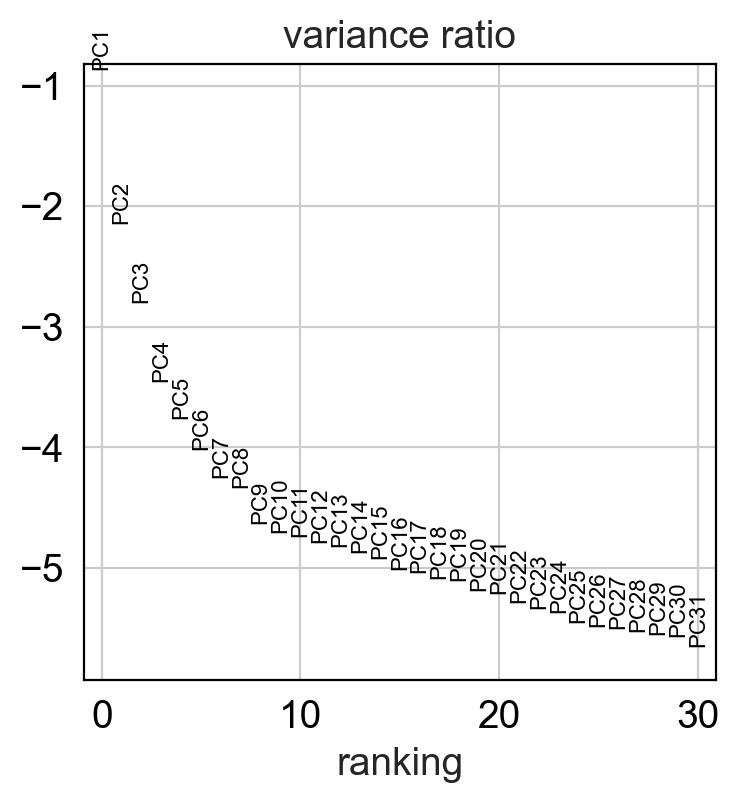

In [16]:
sc.pl.pca_variance_ratio(adata, log=True)


#### Neighbourhood graph

In [17]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [18]:
sc.set_figure_params(dpi_save=300)

## Truncated contagion map of the neighbourhodd graph

In [19]:
# get the neighbourhood graph from the adata object
binarisedMatrix = adata.obsp['connectivities']
binarisedMatrix[binarisedMatrix>0] = 1
neighbourhoodGraph = nx.from_numpy_matrix(binarisedMatrix)

## Explore the influence of the $s$ parameter

In [119]:
from sklearn.metrics import pairwise_distances

s_vec = np.arange(2,61,1)
s_vec = np.append(s_vec,np.inf)
t=0.30


stages = ['primordial','primary','secondary','tertiary','antral']


medianDistancesInternal = []
medianDistancesExternal = []
medianDistancesRatio = []

for s in s_vec:
    print(s)
    contagionMapSingleCellTruncated = cmap.runTruncatedContagionMap(neighbourhoodGraph,threshold=t,numberSteps=s,symmetric=True)
    pca = PCA(n_components=2)
    X_projected_truncated = pca.fit_transform(contagionMapSingleCellTruncated)

    # compute the distances between all celltypes

    sameClusterOut = []
    differentClusterOut = []
    for c1 in stages:
        for c2 in stages: 
            distancesThis = pairwise_distances(contagionMapSingleCellTruncated[adata.obs['stage'] == c1],contagionMapSingleCellTruncated[adata.obs['stage'] == c2])
            medianDistances = np.median(distancesThis)
            # save it to the correct vector
            if (c1==c2):
                sameClusterOut.append(medianDistances)
            else:
                differentClusterOut.append(medianDistances)

    medianSame = np.median(sameClusterOut)
    medianDifferent = np.median(differentClusterOut)
    medianDistancesInternal.append(medianSame)
    medianDistancesExternal.append(medianDifferent)
    medianDistancesRatio.append(medianSame/medianDifferent)



2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
inf


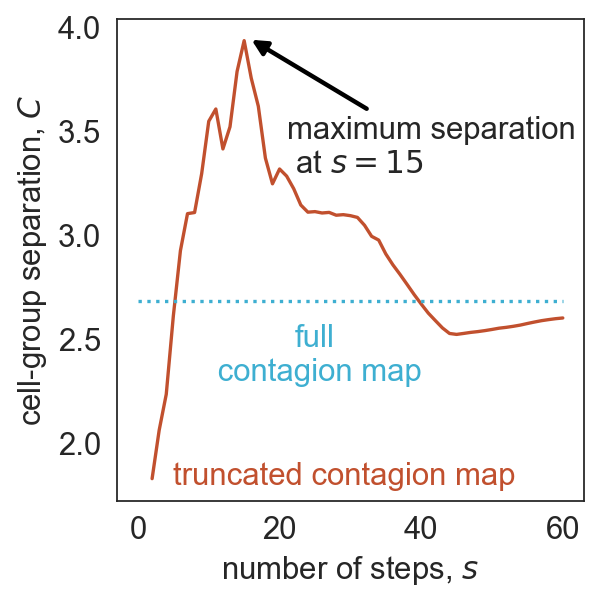

In [179]:




# import matplotlib
# import matplotlib.pyplot as plt
sns.set_style("white")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.plot(s_vec,1/np.array(medianDistancesRatio), color='#c1502e')
plt.hlines(1/medianDistancesRatio[-1],xmin=0,xmax=60,linestyles=':', color='#3eafd1')


# # plt.text(10**1,10**3.8,'full contagion map $\delta t \propto s^{0}$',color='#3eafd1')
plt.text(5,1.8,'truncated contagion map',color='#c1502e')
plt.text(25,2.3,'full\n contagion map',color='#3eafd1',ha='center')


#plt.text(18,3.7,'optimal separation\n at $s=15$',color='#c1502e')


plt.annotate('maximum separation\n at $s=15$', xy=(15.5, 3.95),
             xycoords='data',
             xytext=(21, 3.3),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='k',
                             lw=2,
                             ls='-')
           )

plt.xlabel('number of steps, $s$')
plt.ylabel('cell-group separation, $C$')

plt.tight_layout()
plt.savefig('./figures/Fig8c-singleCell_varyS.pdf')

In [129]:
s_vec[np.argmin(medianDistancesRatio)]

15.0

## Visualisation

[0.86635347 0.10205735]


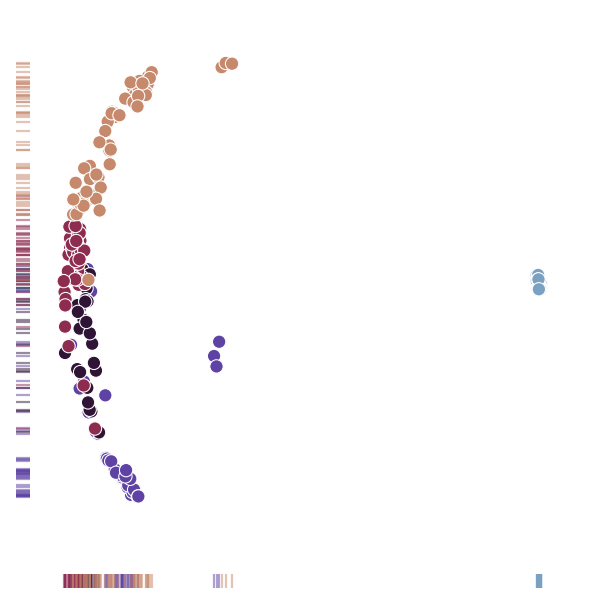

In [180]:
t=0.30
s=15
#s=np.inf

contagionMapSingleCellTruncated = cmap.runTruncatedContagionMap(neighbourhoodGraph,threshold=t,numberSteps=s,symmetric=True)
pca = PCA(n_components=2)
X_projected_truncated = pca.fit_transform(contagionMapSingleCellTruncated)

print(pca.explained_variance_ratio_)



colorPalette = sns.color_palette("twilight",5)

hue_order =['primordial','primary','secondary','tertiary','antral']

sns.scatterplot(x=X_projected_truncated[:,0], y=X_projected_truncated[:,1],hue=adata.obs['stage'],legend=False,palette=colorPalette,hue_order=hue_order)
sns.rugplot(x=X_projected_truncated[:,0], y=X_projected_truncated[:,1],hue=adata.obs['stage'], alpha=.5,legend=None,palette=colorPalette,hue_order=hue_order)

plt.axis('off')

plt.tight_layout()
plt.savefig('./figures/Fig8b-pointcloudOocytes_noLegend_s15.pdf')

In [181]:
# reorder the stages for matrix plot
row_colours= []
for el in adata.obs['stage']:
    row_colours.append(colorPalette[hue_order.index(el)])

/Users/fklimm/mambaforge/envs/TDA/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/fklimm/mambaforge/envs/TDA/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


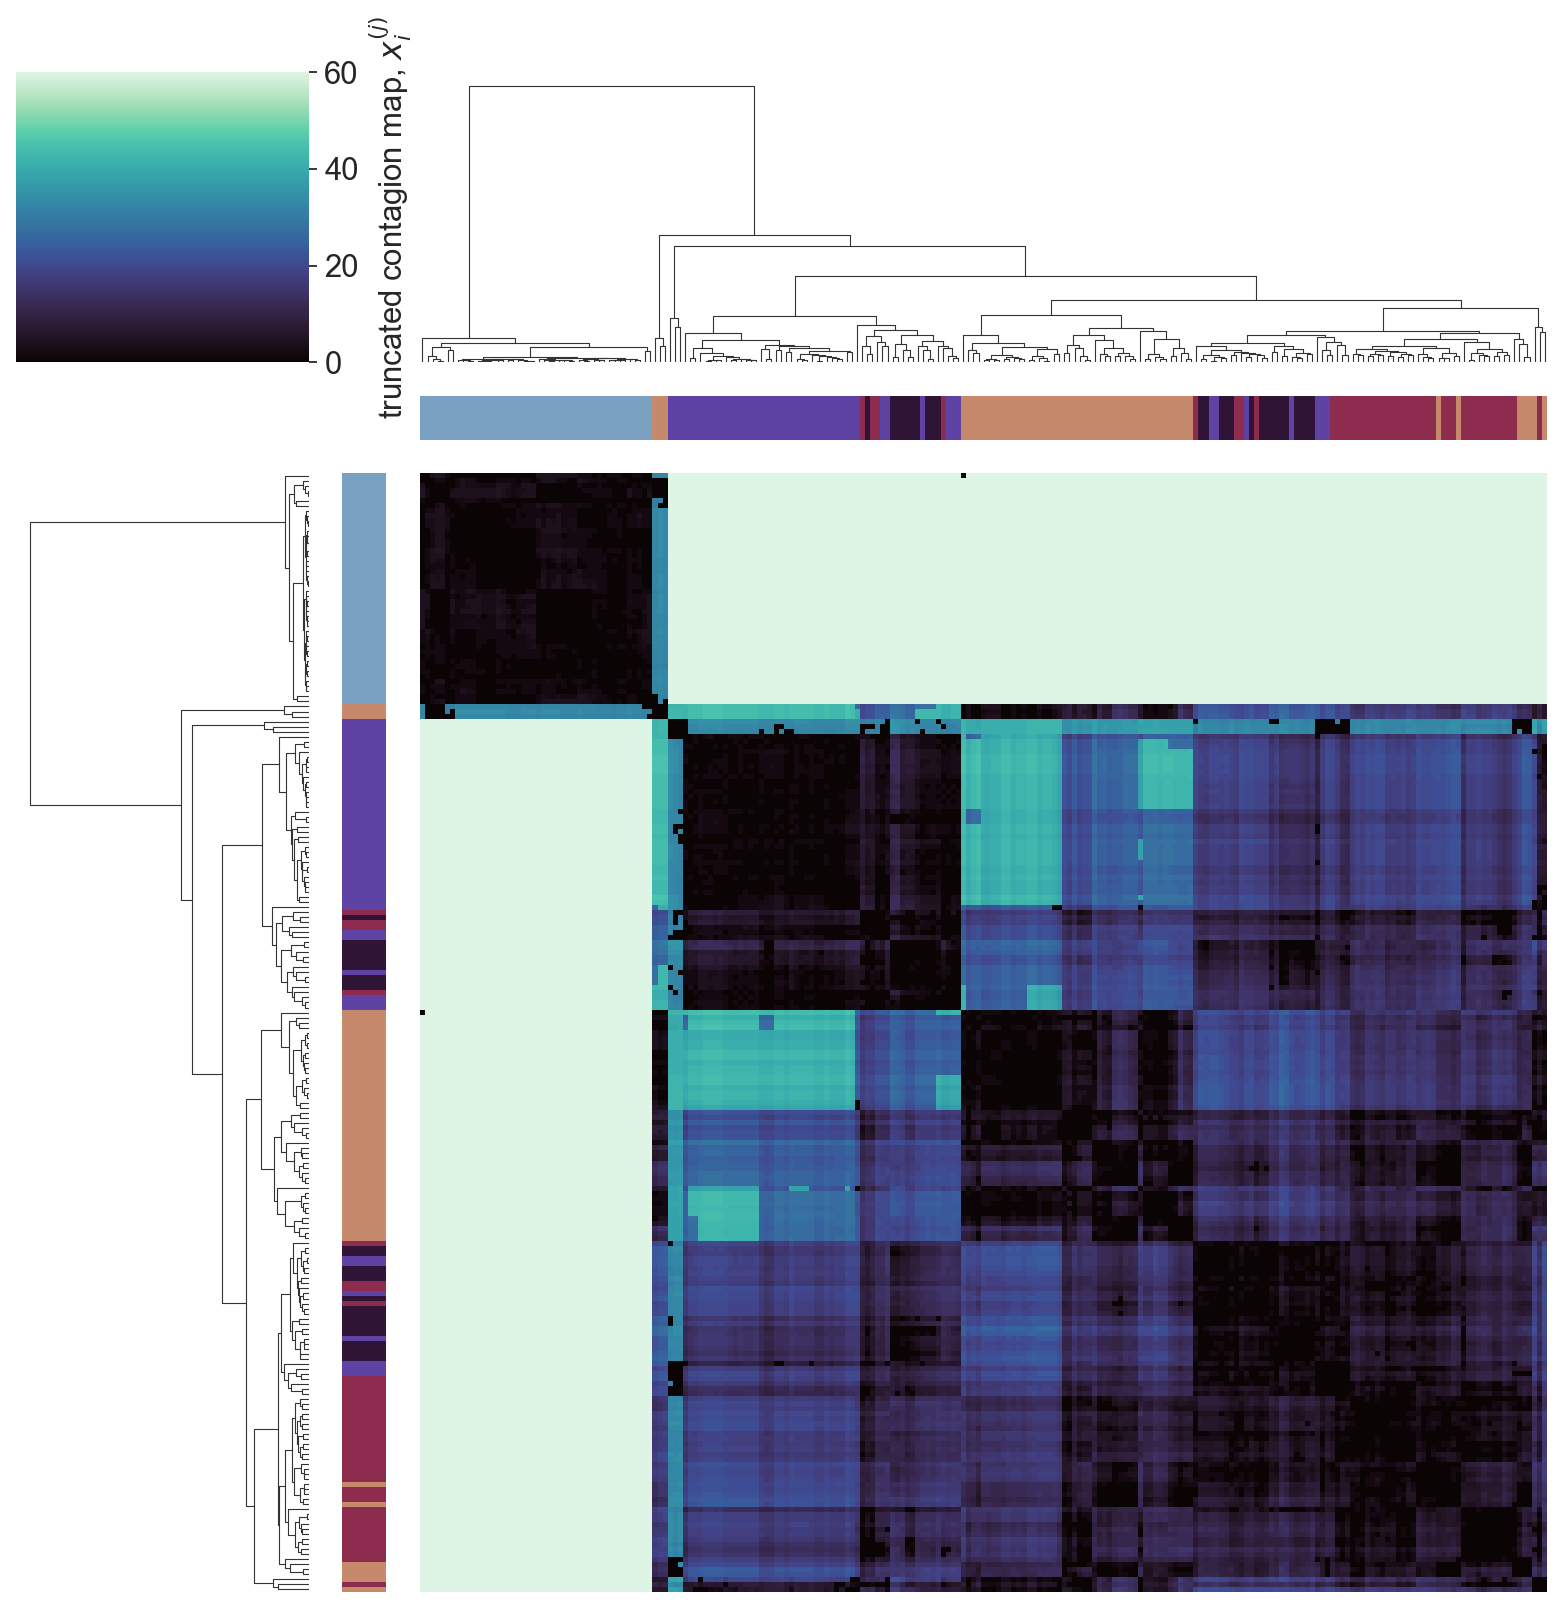

In [182]:
g=sns.clustermap(contagionMapSingleCellTruncated,row_colors=row_colours,col_colors=row_colours,cbar_kws={'label': 'truncated contagion map, $x_i^{(j)}$'}, cmap="mako",yticklabels=False,xticklabels=False)
ax = g.ax_heatmap
ax.tick_params(left=False, bottom=False,right=False)
plt.tight_layout()

plt.savefig('./figures/Fig8a-matrixplotOocytes_s15.pdf')